In [1]:
import tensorflow as tf
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from keras_visualizer import visualizer
from keras import models
from keras.utils.vis_utils import plot_model

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


                               DateTime  Voltage Line 1 [V]  \
DateTime                                                      
2020-08-02 00:00:00 2020-08-02 00:00:00              232.39   
2020-08-02 01:00:00 2020-08-02 01:00:00              234.30   
2020-08-02 02:00:00 2020-08-02 02:00:00              234.14   
2020-08-02 03:00:00 2020-08-02 03:00:00              234.99   
2020-08-02 04:00:00 2020-08-02 04:00:00              233.60   
...                                 ...                 ...   
2020-11-30 19:00:00 2020-11-30 19:00:00              233.59   
2020-11-30 20:00:00 2020-11-30 20:00:00              233.99   
2020-11-30 21:00:00 2020-11-30 21:00:00              233.38   
2020-11-30 22:00:00 2020-11-30 22:00:00              233.50   
2020-11-30 23:00:00 2020-11-30 23:00:00              232.89   

                     Voltage Line 2 [V]  Voltage Line 3 [V]  \
DateTime                                                      
2020-08-02 00:00:00              232.27              2

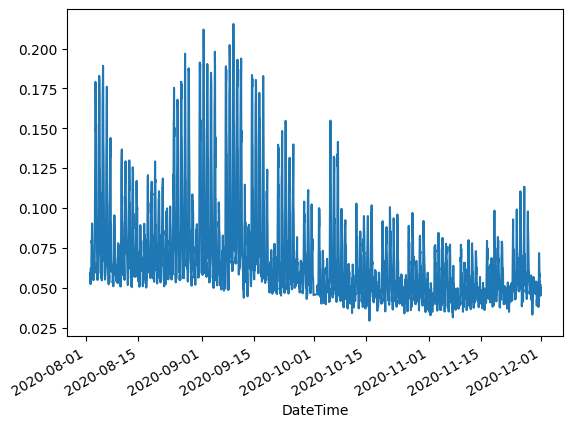

In [2]:
df = pd.read_csv('meter1_combined.csv')
df.DateTime = pd.to_datetime(df.DateTime,dayfirst=True)
df.index = pd.to_datetime(df['DateTime'], format='%d/%m/%Y %H:%M:%S')
df["Active Total Energy in MWh"]= df['Active Total Energy (Wh) [Wh]'].astype(float)/ 1000000
df["Combined Active Power in MW"] = df['Combined Active Power Line 1+2 +3 (watt)'].astype(float) / 1000000
print(df)
df['Combined Active Power in MW'].plot()
# plt.show()
target= df['Combined Active Power in MW']

In [3]:
#Convert TimeSeries
#MODEL WITH JUST POWER
def df_to_X_y(df, window_size=5):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

#Convert TimeSeries
#Uses 5 hrs to predict the next hour ....
WINDOW_SIZE = 2
X1, y1 = df_to_X_y(target, WINDOW_SIZE)
X1.shape, y1.shape

((2876, 2, 1), (2876,))

In [4]:
X_train1, y_train1 = X1[:2000], y1[:2000]
X_val1, y_val1 = X1[2000:2435], y1[2000:2435]
X_test1, y_test1 = X1[2435:], y1[2435:]
print(X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape)

(2000, 2, 1) (2000,) (435, 2, 1) (435,) (441, 2, 1) (441,)


In [35]:
model1 = Sequential()
model1.add(InputLayer(input_shape=(1, 2)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 64)                17152     
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 520       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 17,681
Trainable params: 17,681
Non-trainable params: 0
_________________________________________________________________


In [6]:
cp1 = ModelCheckpoint('model1/', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [7]:
model1.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=50, callbacks=[cp1])
from tensorflow.keras.models import load_model
model1 = load_model('model1/')

Epoch 1/50


ValueError: in user code:

    C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\engine\training.py:830 train_function  *
        return step_function(self, iterator)
    C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\engine\training.py:813 run_step  *
        outputs = model.train_step(data)
    C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\engine\training.py:770 train_step  *
        y_pred = self(x, training=True)
    C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\engine\base_layer.py:1006 __call__  *
        outputs = call_fn(inputs, *args, **kwargs)
    C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\engine\sequential.py:375 call  *
        return super(Sequential, self).call(inputs, training=training, mask=mask)
    C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\engine\functional.py:416 call  *
        inputs, training=training, mask=mask)
    C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\engine\functional.py:551 _run_internal_graph  *
        outputs = node.layer(*args, **kwargs)
    C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\engine\base_layer.py:1006 __call__  *
        outputs = call_fn(inputs, *args, **kwargs)
    C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\engine\functional.py:1442 call  *
        return getattr(self._module, self._method_name)(*args, **kwargs)
    C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tensorflow\python\keras\layers\recurrent.py:668 __call__  **
        return super(RNN, self).__call__(inputs, **kwargs)
    C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tensorflow\python\keras\engine\base_layer.py:1013 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tensorflow\python\keras\engine\input_spec.py:267 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) +

    ValueError: Input 0 is incompatible with layer lstm: expected shape=(None, None, 2), found shape=(None, 2, 1)


In [ ]:
train_predictions = model1.predict(X_train1).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train1})

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_results['Train Predictions'][50:100])
plt.plot(train_results['Actuals'][50:100])
plt.legend(['Actuals','Train Predictions'])
plt.show()

In [ ]:
val_predictions = model1.predict(X_val1).flatten()
val_results = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':y_val1})
val_results

In [ ]:
plt.plot(val_results['Val Predictions'][:100])
plt.plot(val_results['Actuals'][:100])
plt.legend(['Actuals','Validation Predictions'])

In [51]:
test_predictions = model1.predict(X_test1).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test1},index=df['DateTime'][2437:].index)
test_results

ValueError: in user code:

    C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tensorflow\python\keras\engine\training.py:1569 predict_function  *
        return step_function(self, iterator)
    C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tensorflow\python\keras\engine\training.py:1559 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tensorflow\python\distribute\distribute_lib.py:1285 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tensorflow\python\distribute\distribute_lib.py:2833 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tensorflow\python\distribute\distribute_lib.py:3608 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tensorflow\python\keras\engine\training.py:1552 run_step  **
        outputs = model.predict_step(data)
    C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tensorflow\python\keras\engine\training.py:1525 predict_step
        return self(x, training=False)
    C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tensorflow\python\keras\engine\base_layer.py:1013 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tensorflow\python\keras\engine\input_spec.py:267 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) +

    ValueError: Input 0 is incompatible with layer sequential_2: expected shape=(None, None, 2), found shape=(None, 2, 1)


In [ ]:
plt.plot(test_results['Test Predictions'][:100])
plt.plot(test_results['Actuals'][:100])
plt.legend(['Actuals','Test Predictions'])

In [55]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2
from sklearn.metrics import mean_absolute_percentage_error as mape

def plot_predictions1(model, X, y, start=0, end=100):
  predictions = model.predict(X).flatten()
  df = pd.DataFrame(data={'Predictions':predictions, 'Actuals':y})
  plt.plot(df['Predictions'][start:end])
  plt.plot(df['Actuals'][start:end])
  plt.legend(['Actuals','Test Predictions'])
  return df, mse(y, predictions), r2(y,predictions), mape (y,predictions)

#plot_predictions1(model1, X_test1, y_test1)

In [37]:
target.head()

DateTime
2020-08-02 00:00:00    0.056684
2020-08-02 01:00:00    0.059487
2020-08-02 02:00:00    0.052799
2020-08-02 03:00:00    0.055698
2020-08-02 04:00:00    0.052330
Name: Combined Active Power in MW, dtype: float64

In [38]:
temp_df = pd.DataFrame({'Power':target,"Avg Temp":df["Temp"],"High Temp":df['Hi'],"Low Temp":df["Low"]})
temp_df['Seconds'] = temp_df.index.map(pd.Timestamp.timestamp)
temp_df

,Power,Avg Temp,High Temp,Low Temp,Seconds
DateTime,,,,,
2020-08-02 00:00:00,0.056684,28.7,29.6,27.6,1.596326e+09
2020-08-02 01:00:00,0.059487,26.0,27.4,25.2,1.596330e+09
2020-08-02 02:00:00,0.052799,25.9,26.9,25.1,1.596334e+09
2020-08-02 03:00:00,0.055698,25.3,26.4,24.4,1.596337e+09
2020-08-02 04:00:00,0.052330,24.7,26.3,24.1,1.596341e+09
...,...,...,...,...,...
2020-11-30 19:00:00,0.052057,14.4,15.1,14.1,1.606763e+09
2020-11-30 20:00:00,0.044937,13.7,14.2,13.3,1.606766e+09
2020-11-30 21:00:00,0.048803,13.4,13.7,13.2,1.606770e+09


In [39]:
#Adding into consideration the time as a periodic function

day = 60*60*24
month= 30*day
temp_df['Day sin'] = np.sin(temp_df['Seconds'] * (2* np.pi / day))
temp_df['Day cos'] = np.cos(temp_df['Seconds'] * (2 * np.pi / day))
temp_df['Month sin'] = np.sin(temp_df['Seconds'] * (2 * np.pi / month))
temp_df['Month cos'] = np.cos(temp_df['Seconds'] * (2 * np.pi / month))
temp_df

,Power,Avg Temp,High Temp,Low Temp,Seconds,Day sin,Day cos,Month sin,Month cos
DateTime,,,,,,,,,
2020-08-02 00:00:00,0.056684,28.7,29.6,27.6,1.596326e+09,-4.553737e-12,1.000000,-0.743145,0.669131
2020-08-02 01:00:00,0.059487,26.0,27.4,25.2,1.596330e+09,2.588190e-01,0.965926,-0.737277,0.675590
2020-08-02 02:00:00,0.052799,25.9,26.9,25.1,1.596334e+09,5.000000e-01,0.866025,-0.731354,0.681998
2020-08-02 03:00:00,0.055698,25.3,26.4,24.4,1.596337e+09,7.071068e-01,0.707107,-0.725374,0.688355
2020-08-02 04:00:00,0.052330,24.7,26.3,24.1,1.596341e+09,8.660254e-01,0.500000,-0.719340,0.694658
...,...,...,...,...,...,...,...,...,...
2020-11-30 19:00:00,0.052057,14.4,15.1,14.1,1.606763e+09,-9.659258e-01,0.258819,-0.622515,0.782608
2020-11-30 20:00:00,0.044937,13.7,14.2,13.3,1.606766e+09,-8.660254e-01,0.500000,-0.615661,0.788011
2020-11-30 21:00:00,0.048803,13.4,13.7,13.2,1.606770e+09,-7.071068e-01,0.707107,-0.608761,0.793353


In [40]:
temp_df.drop("Seconds",axis=1,inplace=True)
temp_df.head()

,Power,Avg Temp,High Temp,Low Temp,Day sin,Day cos,Month sin,Month cos
DateTime,,,,,,,,
2020-08-02 00:00:00,0.056684,28.7,29.6,27.6,-4.553737e-12,1.000000,-0.743145,0.669131
2020-08-02 01:00:00,0.059487,26.0,27.4,25.2,2.588190e-01,0.965926,-0.737277,0.675590
2020-08-02 02:00:00,0.052799,25.9,26.9,25.1,5.000000e-01,0.866025,-0.731354,0.681998
2020-08-02 03:00:00,0.055698,25.3,26.4,24.4,7.071068e-01,0.707107,-0.725374,0.688355
2020-08-02 04:00:00,0.052330,24.7,26.3,24.1,8.660254e-01,0.500000,-0.719340,0.694658


In [41]:
#Function to create timeseries for multiple parameters
def df_to_X_y2(df, window_size=2):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size][0]
    y.append(label)
  return np.array(X), np.array(y)

In [42]:
X2, y2 = df_to_X_y2(temp_df)
X2.shape, y2.shape

((2876, 2, 8), (2876,))

In [43]:
X2_train, y2_train = X2[:2000], y2[:2000]
X2_val, y2_val = X2[2000:2435], y2[2000:2435]
X2_test, y2_test = X2[2435:], y2[2435:]
X2_train.shape, y2_train.shape, X2_val.shape, y2_val.shape, X2_test.shape, y2_test.shape

((2000, 2, 8), (2000,), (435, 2, 8), (435,), (441, 2, 8), (441,))

In [44]:
#Standardization for the temperatures. Dividing mean/std 
avg_temp_training_mean = np.mean(X2_train[:, :, 1])
avg_temp_training_std = np.std(X2_train[:, :, 1])
hi_temp_training_mean=np.mean(X2_train[:, :, 2])
hi_temp_training_std=np.std(X2_train[:, :, 2])
low_temp_training_mean = np.mean(X2_train[:, :, 3])
low_temp_training_std=np.std(X2_train[:, :, 3])

def preprocess(X):
  X[:, :, 1] = (X[:, :, 1] - avg_temp_training_mean) / avg_temp_training_std
  X[:, :, 2] = (X[:, :, 2] - hi_temp_training_mean) / hi_temp_training_std
  X[:, :, 3] = (X[:, :, 3] - low_temp_training_mean) / low_temp_training_std
  return X

preprocess(X2_train)
preprocess(X2_val)
preprocess(X2_test)

array([[[ 0.07168051, -1.02664378, -1.04978731, ..., -0.96592583,
          0.97629601, -0.21643961],
        [ 0.07084134, -0.94738271, -1.03006985, ..., -0.8660254 ,
          0.97437006, -0.22495105]],

       [[ 0.07084134, -0.94738271, -1.03006985, ..., -0.8660254 ,
          0.97437006, -0.22495105],
        [ 0.06864545, -0.92756745, -0.99063492, ..., -0.70710678,
          0.97236992, -0.23344536]],

       [[ 0.06864545, -0.92756745, -0.99063492, ..., -0.70710678,
          0.97236992, -0.23344536],
        [ 0.05908783, -0.90775218, -0.97091746, ..., -0.5       ,
          0.97029573, -0.2419219 ]],

       ...,

       [[ 0.05205736, -2.21555971, -2.17368271, ...,  0.25881905,
         -0.62251464,  0.78260816],
        [ 0.04493744, -2.35426657, -2.35113988, ...,  0.5       ,
         -0.61566148,  0.78801075]],

       [[ 0.04493744, -2.35426657, -2.35113988, ...,  0.5       ,
         -0.61566148,  0.78801075],
        [ 0.04880258, -2.41371237, -2.44972719, ...,  0.70710

In [45]:
model4 = Sequential()
model4.add(InputLayer((2, 8)))
model4.add(LSTM(64))
model4.add(Dense(8, 'relu'))
model4.add(Dense(1, 'linear'))

model4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 64)                18688     
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 520       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 9         
Total params: 19,217
Trainable params: 19,217
Non-trainable params: 0
_________________________________________________________________


In [46]:
cp4 = ModelCheckpoint('model4/', save_best_only=True)
model4.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [49]:
model4.fit(X2_train, y2_train, validation_data=(X2_val, y2_val), epochs=50, callbacks=[cp4])

Epoch 1/50
63/63 [==============================] - 0s 3ms/step - loss: 1.2119e-04 - root_mean_squared_error: 0.0110 - val_loss: 1.3196e-04 - val_root_mean_squared_error: 0.0115
Epoch 2/50
63/63 [==============================] - 0s 3ms/step - loss: 1.1805e-04 - root_mean_squared_error: 0.0109 - val_loss: 1.0531e-04 - val_root_mean_squared_error: 0.0103


INFO:tensorflow:Assets written to: model4\assets


INFO:tensorflow:Assets written to: model4\assets


Epoch 3/50
63/63 [==============================] - 0s 3ms/step - loss: 1.1350e-04 - root_mean_squared_error: 0.0107 - val_loss: 1.2338e-04 - val_root_mean_squared_error: 0.0111
Epoch 4/50
63/63 [==============================] - 0s 3ms/step - loss: 1.1093e-04 - root_mean_squared_error: 0.0105 - val_loss: 1.0770e-04 - val_root_mean_squared_error: 0.0104
Epoch 5/50
63/63 [==============================] - 0s 3ms/step - loss: 1.1180e-04 - root_mean_squared_error: 0.0106 - val_loss: 1.1081e-04 - val_root_mean_squared_error: 0.0105
Epoch 6/50
63/63 [==============================] - 0s 3ms/step - loss: 1.0865e-04 - root_mean_squared_error: 0.0104 - val_loss: 9.9879e-05 - val_root_mean_squared_error: 0.0100


INFO:tensorflow:Assets written to: model4\assets


INFO:tensorflow:Assets written to: model4\assets


Epoch 7/50
63/63 [==============================] - 0s 3ms/step - loss: 1.0731e-04 - root_mean_squared_error: 0.0104 - val_loss: 1.0532e-04 - val_root_mean_squared_error: 0.0103
Epoch 8/50
63/63 [==============================] - 0s 3ms/step - loss: 1.0492e-04 - root_mean_squared_error: 0.0102 - val_loss: 1.1833e-04 - val_root_mean_squared_error: 0.0109
Epoch 9/50
63/63 [==============================] - 0s 3ms/step - loss: 1.0480e-04 - root_mean_squared_error: 0.0102 - val_loss: 9.7028e-05 - val_root_mean_squared_error: 0.0099


INFO:tensorflow:Assets written to: model4\assets


INFO:tensorflow:Assets written to: model4\assets


Epoch 10/50
63/63 [==============================] - 0s 3ms/step - loss: 1.0441e-04 - root_mean_squared_error: 0.0102 - val_loss: 9.5602e-05 - val_root_mean_squared_error: 0.0098


INFO:tensorflow:Assets written to: model4\assets


INFO:tensorflow:Assets written to: model4\assets


Epoch 11/50
63/63 [==============================] - 0s 3ms/step - loss: 1.0380e-04 - root_mean_squared_error: 0.0102 - val_loss: 9.8340e-05 - val_root_mean_squared_error: 0.0099
Epoch 12/50
63/63 [==============================] - 0s 3ms/step - loss: 1.0247e-04 - root_mean_squared_error: 0.0101 - val_loss: 9.5556e-05 - val_root_mean_squared_error: 0.0098


INFO:tensorflow:Assets written to: model4\assets


INFO:tensorflow:Assets written to: model4\assets


Epoch 13/50
63/63 [==============================] - 0s 3ms/step - loss: 1.0033e-04 - root_mean_squared_error: 0.0100 - val_loss: 1.0660e-04 - val_root_mean_squared_error: 0.0103
Epoch 14/50
63/63 [==============================] - 0s 3ms/step - loss: 1.0158e-04 - root_mean_squared_error: 0.0101 - val_loss: 9.5932e-05 - val_root_mean_squared_error: 0.0098
Epoch 15/50
63/63 [==============================] - 0s 3ms/step - loss: 9.9353e-05 - root_mean_squared_error: 0.0100 - val_loss: 9.4405e-05 - val_root_mean_squared_error: 0.0097


INFO:tensorflow:Assets written to: model4\assets


INFO:tensorflow:Assets written to: model4\assets


Epoch 16/50
63/63 [==============================] - 0s 3ms/step - loss: 9.8140e-05 - root_mean_squared_error: 0.0099 - val_loss: 8.9807e-05 - val_root_mean_squared_error: 0.0095


INFO:tensorflow:Assets written to: model4\assets


INFO:tensorflow:Assets written to: model4\assets


Epoch 17/50
63/63 [==============================] - 0s 3ms/step - loss: 9.7823e-05 - root_mean_squared_error: 0.0099 - val_loss: 8.2572e-05 - val_root_mean_squared_error: 0.0091


INFO:tensorflow:Assets written to: model4\assets


INFO:tensorflow:Assets written to: model4\assets


Epoch 18/50
63/63 [==============================] - 0s 3ms/step - loss: 9.6911e-05 - root_mean_squared_error: 0.0098 - val_loss: 1.0744e-04 - val_root_mean_squared_error: 0.0104
Epoch 19/50
63/63 [==============================] - 0s 3ms/step - loss: 9.7501e-05 - root_mean_squared_error: 0.0099 - val_loss: 7.6573e-05 - val_root_mean_squared_error: 0.0088


INFO:tensorflow:Assets written to: model4\assets


INFO:tensorflow:Assets written to: model4\assets


Epoch 20/50
63/63 [==============================] - 0s 3ms/step - loss: 9.3693e-05 - root_mean_squared_error: 0.0097 - val_loss: 1.0589e-04 - val_root_mean_squared_error: 0.0103
Epoch 21/50
63/63 [==============================] - 0s 3ms/step - loss: 9.5264e-05 - root_mean_squared_error: 0.0098 - val_loss: 9.1145e-05 - val_root_mean_squared_error: 0.0095
Epoch 22/50
63/63 [==============================] - 0s 3ms/step - loss: 9.3372e-05 - root_mean_squared_error: 0.0097 - val_loss: 9.0825e-05 - val_root_mean_squared_error: 0.0095
Epoch 23/50
63/63 [==============================] - 0s 3ms/step - loss: 9.7087e-05 - root_mean_squared_error: 0.0099 - val_loss: 7.8795e-05 - val_root_mean_squared_error: 0.0089
Epoch 24/50
63/63 [==============================] - 0s 3ms/step - loss: 9.3281e-05 - root_mean_squared_error: 0.0097 - val_loss: 9.3012e-05 - val_root_mean_squared_error: 0.0096
Epoch 25/50
63/63 [==============================] - 0s 3ms/step - loss: 9.2386e-05 - root_mean_squared_e

INFO:tensorflow:Assets written to: model4\assets


INFO:tensorflow:Assets written to: model4\assets


Epoch 34/50
63/63 [==============================] - 0s 3ms/step - loss: 8.8247e-05 - root_mean_squared_error: 0.0094 - val_loss: 8.9062e-05 - val_root_mean_squared_error: 0.0094
Epoch 35/50
63/63 [==============================] - 0s 3ms/step - loss: 8.9856e-05 - root_mean_squared_error: 0.0095 - val_loss: 8.0237e-05 - val_root_mean_squared_error: 0.0090
Epoch 36/50
63/63 [==============================] - 0s 3ms/step - loss: 8.7302e-05 - root_mean_squared_error: 0.0093 - val_loss: 7.7541e-05 - val_root_mean_squared_error: 0.0088
Epoch 37/50
63/63 [==============================] - 0s 3ms/step - loss: 8.6302e-05 - root_mean_squared_error: 0.0093 - val_loss: 7.0953e-05 - val_root_mean_squared_error: 0.0084
Epoch 38/50
63/63 [==============================] - 0s 3ms/step - loss: 8.6682e-05 - root_mean_squared_error: 0.0093 - val_loss: 7.9451e-05 - val_root_mean_squared_error: 0.0089
Epoch 39/50
63/63 [==============================] - 0s 3ms/step - loss: 8.5350e-05 - root_mean_squared_e

INFO:tensorflow:Assets written to: model4\assets


INFO:tensorflow:Assets written to: model4\assets


Epoch 45/50
63/63 [==============================] - 0s 3ms/step - loss: 8.4367e-05 - root_mean_squared_error: 0.0092 - val_loss: 8.4379e-05 - val_root_mean_squared_error: 0.0092
Epoch 46/50
63/63 [==============================] - 0s 3ms/step - loss: 8.5337e-05 - root_mean_squared_error: 0.0092 - val_loss: 7.6235e-05 - val_root_mean_squared_error: 0.0087
Epoch 47/50
63/63 [==============================] - 0s 3ms/step - loss: 8.3264e-05 - root_mean_squared_error: 0.0091 - val_loss: 8.5304e-05 - val_root_mean_squared_error: 0.0092
Epoch 48/50
63/63 [==============================] - 0s 3ms/step - loss: 8.3276e-05 - root_mean_squared_error: 0.0091 - val_loss: 7.2389e-05 - val_root_mean_squared_error: 0.0085
Epoch 49/50
63/63 [==============================] - 0s 3ms/step - loss: 8.4449e-05 - root_mean_squared_error: 0.0092 - val_loss: 7.7410e-05 - val_root_mean_squared_error: 0.0088
Epoch 50/50
63/63 [==============================] - 0s 3ms/step - loss: 8.4088e-05 - root_mean_squared_e

8.148613153970935e-05 0.5530572518947209 0.12219304960163604


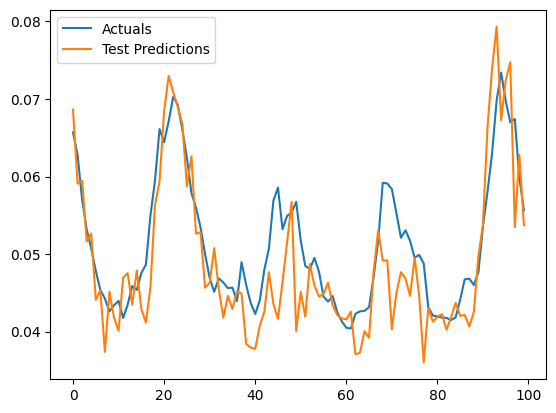

In [56]:


final, mse_val, r2_val, mape_value = plot_predictions1(model4, X2_test, y2_test)
print(mse_val, r2_val, mape_value)

In [53]:
test_predictions = model4.predict(X2_test).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test1},index=df['DateTime'][2437:].index)
test_results

,Test Predictions,Actuals
DateTime,,
2020-11-12 15:00:00,0.065699,0.068645
2020-11-12 16:00:00,0.062837,0.059088
2020-11-12 17:00:00,0.057017,0.059466
2020-11-12 18:00:00,0.053218,0.051650
2020-11-12 19:00:00,0.050727,0.052649
...,...,...
2020-11-30 19:00:00,0.036935,0.052057
2020-11-30 20:00:00,0.038012,0.044937
2020-11-30 21:00:00,0.040726,0.048803


Text(0, 0.5, 'Active Power in MW')

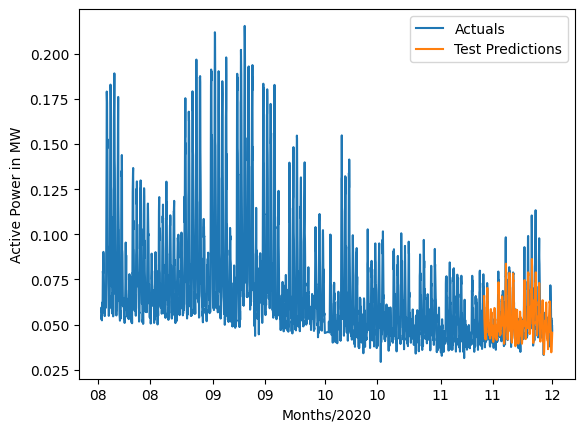

In [54]:
import matplotlib.dates as mdates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m'))
fig=plt.plot(target)#[:100])    
fig=plt.plot(test_results['Test Predictions']) 
plt.legend(['Actuals','Test Predictions'])    
plt.xlabel("Months/2020")
plt.ylabel("Active Power in MW")

In [ ]:
plot_predictions1(model4, X2_train, y2_train)

In [11]:
#Prediction without using time as a parameter (Just Temperature)
new_df= pd.DataFrame({'Power':target,"Avg Temp":df["Temp"],"High Temp":df['Hi'],"Low Temp":df["Low"]})
new_df

,Power,Avg Temp,High Temp,Low Temp
DateTime,,,,
2020-08-02 00:00:00,0.056684,28.7,29.6,27.6
2020-08-02 01:00:00,0.059487,26.0,27.4,25.2
2020-08-02 02:00:00,0.052799,25.9,26.9,25.1
2020-08-02 03:00:00,0.055698,25.3,26.4,24.4
2020-08-02 04:00:00,0.052330,24.7,26.3,24.1
...,...,...,...,...
2020-11-30 19:00:00,0.052057,14.4,15.1,14.1
2020-11-30 20:00:00,0.044937,13.7,14.2,13.3
2020-11-30 21:00:00,0.048803,13.4,13.7,13.2


In [14]:
X3, y3 = df_to_X_y2(new_df)
X3.shape, y3.shape

((2876, 2, 4), (2876,))

In [15]:
X3_train, y3_train = X3[:2000], y3[:2000]
X3_val, y3_val = X3[2000:2435], y3[2000:2435]
X3_test, y3_test = X3[2435:], y3[2435:]
X3_train.shape, y3_train.shape, X3_val.shape, y3_val.shape, X3_test.shape, y3_test.shape

((2000, 2, 4), (2000,), (435, 2, 4), (435,), (441, 2, 4), (441,))

In [16]:
avg_temp_training_mean = np.mean(X3_train[:, :, 1])
avg_temp_training_std = np.std(X3_train[:, :, 1])
hi_temp_training_mean=np.mean(X3_train[:, :, 2])
hi_temp_training_std=np.std(X3_train[:, :, 2])
low_temp_training_mean = np.mean(X3_train[:, :, 3])
low_temp_training_std=np.std(X3_train[:, :, 3])

def preprocess(X):
  X[:, :, 1] = (X[:, :, 1] - avg_temp_training_mean) / avg_temp_training_std
  X[:, :, 2] = (X[:, :, 2] - hi_temp_training_mean) / hi_temp_training_std
  X[:, :, 3] = (X[:, :, 3] - low_temp_training_mean) / low_temp_training_std
  return X

preprocess(X3_train)
preprocess(X3_val)
preprocess(X3_test)

array([[[ 0.07168051, -1.02664378, -1.04978731, -0.96356103],
        [ 0.07084134, -0.94738271, -1.03006985, -0.86400983]],

       [[ 0.07084134, -0.94738271, -1.03006985, -0.86400983],
        [ 0.06864545, -0.92756745, -0.99063492, -0.88392007]],

       [[ 0.06864545, -0.92756745, -0.99063492, -0.88392007],
        [ 0.05908783, -0.90775218, -0.97091746, -0.84409959]],

       ...,

       [[ 0.05205736, -2.21555971, -2.17368271, -2.17808566],
        [ 0.04493744, -2.35426657, -2.35113988, -2.33736758]],

       [[ 0.04493744, -2.35426657, -2.35113988, -2.33736758],
        [ 0.04880258, -2.41371237, -2.44972719, -2.35727782]],

       [[ 0.04880258, -2.41371237, -2.44972719, -2.35727782],
        [ 0.04958546, -2.4533429 , -2.44972719, -2.45682902]]])

In [17]:
model5 = Sequential()
model5.add(InputLayer((2, 4)))
model5.add(LSTM(64))
model5.add(Dense(8, 'relu'))
model5.add(Dense(1, 'linear'))

model5.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 64)                17664     
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 520       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 18,193
Trainable params: 18,193
Non-trainable params: 0
_________________________________________________________________


In [18]:
cp5 = ModelCheckpoint('model5/', save_best_only=True)
model5.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [20]:
model5.fit(X3_train, y3_train, validation_data=(X3_val, y3_val), epochs=50, callbacks=[cp5])

Epoch 1/50
63/63 [==============================] - 3s 12ms/step - loss: 0.0147 - root_mean_squared_error: 0.1196 - val_loss: 9.6259e-04 - val_root_mean_squared_error: 0.0310


INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


Epoch 2/50
63/63 [==============================] - 0s 3ms/step - loss: 0.0022 - root_mean_squared_error: 0.0473 - val_loss: 6.8213e-04 - val_root_mean_squared_error: 0.0261


INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


Epoch 3/50
63/63 [==============================] - 0s 3ms/step - loss: 0.0015 - root_mean_squared_error: 0.0386 - val_loss: 4.8816e-04 - val_root_mean_squared_error: 0.0221


INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


Epoch 4/50
63/63 [==============================] - 0s 3ms/step - loss: 0.0012 - root_mean_squared_error: 0.0339 - val_loss: 4.1630e-04 - val_root_mean_squared_error: 0.0204


INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


Epoch 5/50
63/63 [==============================] - 0s 3ms/step - loss: 0.0011 - root_mean_squared_error: 0.0328 - val_loss: 3.3393e-04 - val_root_mean_squared_error: 0.0183


INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


Epoch 6/50
63/63 [==============================] - 0s 3ms/step - loss: 0.0010 - root_mean_squared_error: 0.0319 - val_loss: 3.3213e-04 - val_root_mean_squared_error: 0.0182


INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


Epoch 7/50
63/63 [==============================] - 0s 3ms/step - loss: 0.0010 - root_mean_squared_error: 0.0317 - val_loss: 2.9131e-04 - val_root_mean_squared_error: 0.0171


INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


Epoch 8/50
63/63 [==============================] - 0s 3ms/step - loss: 0.0010 - root_mean_squared_error: 0.0320 - val_loss: 2.7153e-04 - val_root_mean_squared_error: 0.0165


INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


Epoch 9/50
63/63 [==============================] - 0s 3ms/step - loss: 9.4375e-04 - root_mean_squared_error: 0.0307 - val_loss: 2.8725e-04 - val_root_mean_squared_error: 0.0169
Epoch 10/50
63/63 [==============================] - 0s 3ms/step - loss: 9.4853e-04 - root_mean_squared_error: 0.0308 - val_loss: 2.3726e-04 - val_root_mean_squared_error: 0.0154


INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


Epoch 11/50
63/63 [==============================] - 0s 3ms/step - loss: 8.7897e-04 - root_mean_squared_error: 0.0296 - val_loss: 2.5335e-04 - val_root_mean_squared_error: 0.0159
Epoch 12/50
63/63 [==============================] - 0s 3ms/step - loss: 8.7255e-04 - root_mean_squared_error: 0.0295 - val_loss: 2.3342e-04 - val_root_mean_squared_error: 0.0153


INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


Epoch 13/50
63/63 [==============================] - 0s 3ms/step - loss: 7.9710e-04 - root_mean_squared_error: 0.0282 - val_loss: 3.0514e-04 - val_root_mean_squared_error: 0.0175
Epoch 14/50
63/63 [==============================] - 0s 3ms/step - loss: 7.9435e-04 - root_mean_squared_error: 0.0282 - val_loss: 2.3370e-04 - val_root_mean_squared_error: 0.0153
Epoch 15/50
63/63 [==============================] - 0s 3ms/step - loss: 6.9045e-04 - root_mean_squared_error: 0.0262 - val_loss: 2.4494e-04 - val_root_mean_squared_error: 0.0157
Epoch 16/50
63/63 [==============================] - 0s 3ms/step - loss: 7.4593e-04 - root_mean_squared_error: 0.0272 - val_loss: 1.9898e-04 - val_root_mean_squared_error: 0.0141


INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


Epoch 17/50
63/63 [==============================] - 0s 3ms/step - loss: 5.9619e-04 - root_mean_squared_error: 0.0244 - val_loss: 2.0521e-04 - val_root_mean_squared_error: 0.0143
Epoch 18/50
63/63 [==============================] - 0s 3ms/step - loss: 5.9870e-04 - root_mean_squared_error: 0.0244 - val_loss: 2.4107e-04 - val_root_mean_squared_error: 0.0155
Epoch 19/50
63/63 [==============================] - 0s 3ms/step - loss: 5.6052e-04 - root_mean_squared_error: 0.0237 - val_loss: 1.9233e-04 - val_root_mean_squared_error: 0.0139


INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


Epoch 20/50
63/63 [==============================] - 0s 3ms/step - loss: 5.4941e-04 - root_mean_squared_error: 0.0234 - val_loss: 2.5825e-04 - val_root_mean_squared_error: 0.0161
Epoch 21/50
63/63 [==============================] - 0s 3ms/step - loss: 5.2250e-04 - root_mean_squared_error: 0.0229 - val_loss: 2.3997e-04 - val_root_mean_squared_error: 0.0155
Epoch 22/50
63/63 [==============================] - 0s 3ms/step - loss: 5.3348e-04 - root_mean_squared_error: 0.0231 - val_loss: 1.8083e-04 - val_root_mean_squared_error: 0.0134


INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


Epoch 23/50
63/63 [==============================] - 0s 3ms/step - loss: 4.9158e-04 - root_mean_squared_error: 0.0222 - val_loss: 1.7579e-04 - val_root_mean_squared_error: 0.0133


INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


Epoch 24/50
63/63 [==============================] - 0s 3ms/step - loss: 4.8489e-04 - root_mean_squared_error: 0.0220 - val_loss: 1.7011e-04 - val_root_mean_squared_error: 0.0130


INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


Epoch 25/50
63/63 [==============================] - 0s 3ms/step - loss: 4.5427e-04 - root_mean_squared_error: 0.0213 - val_loss: 1.6255e-04 - val_root_mean_squared_error: 0.0127


INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


Epoch 26/50
63/63 [==============================] - 0s 3ms/step - loss: 4.5595e-04 - root_mean_squared_error: 0.0213 - val_loss: 1.4358e-04 - val_root_mean_squared_error: 0.0120


INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


Epoch 27/50
63/63 [==============================] - 0s 3ms/step - loss: 4.8384e-04 - root_mean_squared_error: 0.0219 - val_loss: 1.8473e-04 - val_root_mean_squared_error: 0.0136
Epoch 28/50
63/63 [==============================] - 0s 3ms/step - loss: 3.9224e-04 - root_mean_squared_error: 0.0198 - val_loss: 1.7455e-04 - val_root_mean_squared_error: 0.0132
Epoch 29/50
63/63 [==============================] - 0s 3ms/step - loss: 3.6914e-04 - root_mean_squared_error: 0.0192 - val_loss: 1.5043e-04 - val_root_mean_squared_error: 0.0123
Epoch 30/50
63/63 [==============================] - 0s 3ms/step - loss: 3.5791e-04 - root_mean_squared_error: 0.0189 - val_loss: 1.5866e-04 - val_root_mean_squared_error: 0.0126
Epoch 31/50
63/63 [==============================] - 0s 3ms/step - loss: 3.2003e-04 - root_mean_squared_error: 0.0178 - val_loss: 1.3426e-04 - val_root_mean_squared_error: 0.0116


INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


Epoch 32/50
63/63 [==============================] - 0s 3ms/step - loss: 3.3051e-04 - root_mean_squared_error: 0.0182 - val_loss: 1.1894e-04 - val_root_mean_squared_error: 0.0109


INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


Epoch 33/50
63/63 [==============================] - 0s 3ms/step - loss: 3.5209e-04 - root_mean_squared_error: 0.0187 - val_loss: 1.7576e-04 - val_root_mean_squared_error: 0.0133
Epoch 34/50
63/63 [==============================] - 0s 3ms/step - loss: 3.2154e-04 - root_mean_squared_error: 0.0179 - val_loss: 1.0489e-04 - val_root_mean_squared_error: 0.0102


INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


Epoch 35/50
63/63 [==============================] - 0s 3ms/step - loss: 2.9798e-04 - root_mean_squared_error: 0.0172 - val_loss: 8.5550e-05 - val_root_mean_squared_error: 0.0092


INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


Epoch 36/50
63/63 [==============================] - 0s 3ms/step - loss: 2.6041e-04 - root_mean_squared_error: 0.0161 - val_loss: 6.6808e-05 - val_root_mean_squared_error: 0.0082


INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


Epoch 37/50
63/63 [==============================] - 0s 3ms/step - loss: 2.8360e-04 - root_mean_squared_error: 0.0168 - val_loss: 1.0997e-04 - val_root_mean_squared_error: 0.0105
Epoch 38/50
63/63 [==============================] - 0s 3ms/step - loss: 2.8526e-04 - root_mean_squared_error: 0.0169 - val_loss: 6.3344e-05 - val_root_mean_squared_error: 0.0080


INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


Epoch 39/50
63/63 [==============================] - 0s 3ms/step - loss: 2.7415e-04 - root_mean_squared_error: 0.0165 - val_loss: 1.3306e-04 - val_root_mean_squared_error: 0.0115
Epoch 40/50
63/63 [==============================] - 0s 3ms/step - loss: 2.6108e-04 - root_mean_squared_error: 0.0162 - val_loss: 1.0619e-04 - val_root_mean_squared_error: 0.0103
Epoch 41/50
63/63 [==============================] - 0s 3ms/step - loss: 2.5222e-04 - root_mean_squared_error: 0.0159 - val_loss: 1.1141e-04 - val_root_mean_squared_error: 0.0106
Epoch 42/50
63/63 [==============================] - 0s 3ms/step - loss: 2.4089e-04 - root_mean_squared_error: 0.0155 - val_loss: 1.1825e-04 - val_root_mean_squared_error: 0.0109
Epoch 43/50
63/63 [==============================] - 0s 3ms/step - loss: 2.4787e-04 - root_mean_squared_error: 0.0157 - val_loss: 1.0736e-04 - val_root_mean_squared_error: 0.0104
Epoch 44/50
63/63 [==============================] - 0s 3ms/step - loss: 2.5198e-04 - root_mean_squared_e

INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


Epoch 46/50
63/63 [==============================] - 0s 3ms/step - loss: 2.3123e-04 - root_mean_squared_error: 0.0152 - val_loss: 7.0763e-05 - val_root_mean_squared_error: 0.0084
Epoch 47/50
63/63 [==============================] - 0s 3ms/step - loss: 2.2244e-04 - root_mean_squared_error: 0.0149 - val_loss: 5.4067e-05 - val_root_mean_squared_error: 0.0074


INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


Epoch 48/50
63/63 [==============================] - 0s 3ms/step - loss: 2.3419e-04 - root_mean_squared_error: 0.0153 - val_loss: 1.0524e-04 - val_root_mean_squared_error: 0.0103
Epoch 49/50
63/63 [==============================] - 0s 3ms/step - loss: 2.3552e-04 - root_mean_squared_error: 0.0153 - val_loss: 5.8591e-05 - val_root_mean_squared_error: 0.0077
Epoch 50/50
63/63 [==============================] - 0s 3ms/step - loss: 2.1466e-04 - root_mean_squared_error: 0.0146 - val_loss: 6.4043e-05 - val_root_mean_squared_error: 0.0080


6.851332547219246e-05 0.6242117107565621 0.12471040057346115


,Predictions,Actuals
0,0.073385,0.068645
1,0.072509,0.059088
2,0.066878,0.059466
3,0.060737,0.051650
4,0.055585,0.052649
...,...,...
436,0.056139,0.052057
437,0.049812,0.044937
438,0.050695,0.048803
439,0.050667,0.049585


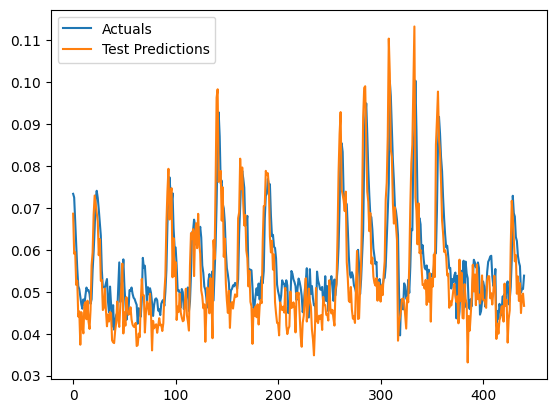

In [33]:
final, mse_value, r2_value, mape_value = plot_predictions1(model5, X3_test, y3_test)
print(mse_value,r2_value,mape_value)
final



In [30]:

# final=final.set_index(df['DateTime'][2437:].index)
# print(final)
test_predictions = model5.predict(X3_test).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test1},index=df['DateTime'][2437:].index)
test_results

,Test Predictions,Actuals
DateTime,,
2020-11-12 15:00:00,0.073385,0.068645
2020-11-12 16:00:00,0.072509,0.059088
2020-11-12 17:00:00,0.066878,0.059466
2020-11-12 18:00:00,0.060737,0.051650
2020-11-12 19:00:00,0.055585,0.052649
...,...,...
2020-11-30 19:00:00,0.056139,0.052057
2020-11-30 20:00:00,0.049812,0.044937
2020-11-30 21:00:00,0.050695,0.048803


Text(0, 0.5, 'Active Power in MW')

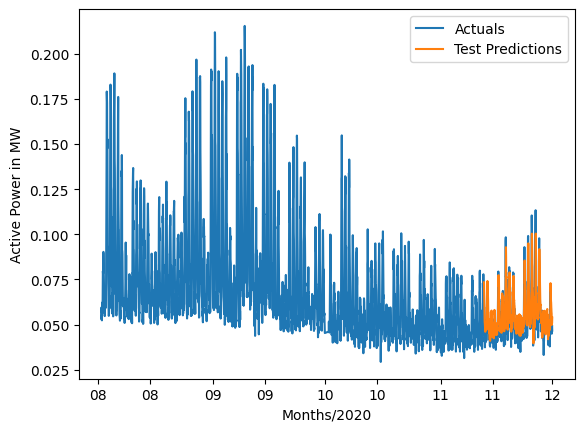

In [31]:
import matplotlib.dates as mdates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m'))
fig=plt.plot(target)#[:100])    
fig=plt.plot(test_results['Test Predictions']) 
plt.legend(['Actuals','Test Predictions'])    
plt.xlabel("Months/2020")
plt.ylabel("Active Power in MW")